In [19]:
# !pip install gym==0.25.2
# !pip install swig
# !pip install gym[box2d]

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import random
from collections import deque
import os

In [21]:
checkpoint_path = 'gdqn_kld2.pth'

In [22]:
class GaussianDQN(nn.Module):
    def __init__(self, state_dim, action_dim,hidden_dim=256):
        super(GaussianDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        self.log_std_head = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean_head(x)
        log_std = self.log_std_head(x)
        std = torch.exp(log_std)
        return mean, std

In [23]:
# def compute_loss(pred_mean, pred_std, target_mean, target_std):
#     # Huber Loss
#     mse_loss = nn.MSELoss()
#     # The loss considers both mean and standard deviation
#     mean_loss = mse_loss(pred_mean, target_mean)
#     std_loss = mse_loss(pred_std, target_std)
#     return mean_loss + std_loss

In [24]:
def compute_loss(pred_mean, pred_std, target_mean, target_std):
    kl_div = torch.log(target_std / pred_std) + (pred_std**2 + (pred_mean - target_mean)**2) / (2 * target_std**2) - 0.5
    return kl_div.mean()

In [25]:
def select_action(state, network, epsilon, action_dim,device):
    if np.random.rand() < epsilon:
        return np.random.randint(action_dim)
    else:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            mean, _ = network(state)
        return mean.argmax().item()

In [26]:
def save_checkpoint(state, filename='checkpoint.pth'):
    torch.save(state, filename)

In [27]:
def load_checkpoint(filename='checkpoint.pth', map_location=None):
    if map_location:
        return torch.load(filename, map_location=map_location)
    return torch.load(filename)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
num_episodes=1000
batch_size=64
gamma=0.99
epsilon_start=1.0
epsilon_end=0.1
epsilon_decay=0.995


In [30]:
replay_buffer = deque(maxlen=100000)
epsilon = epsilon_start
update_target_steps = 10000
total_steps = 0

In [31]:
env = gym.make("LunarLander-v2")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128

network = GaussianDQN(state_dim, action_dim,hidden_dim).to(device)
target_network = GaussianDQN(state_dim, action_dim,hidden_dim).to(device)

/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [32]:
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [33]:
try:
    map_location = torch.device('cpu') if not torch.cuda.is_available() else None
    checkpoint = load_checkpoint(checkpoint_path, map_location=map_location)
    network.load_state_dict(checkpoint['main_net_state_dict'])
    target_network.load_state_dict(checkpoint['target_net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epsilon = checkpoint['epsilon']
    start_episode = checkpoint['episode'] + 1
    print(f"Loaded checkpoint from episode {start_episode}")
except FileNotFoundError:
    print("No checkpoint found, starting from scratch.")

Loaded checkpoint from episode 51


In [34]:

target_network.load_state_dict(network.state_dict())


<All keys matched successfully>

In [35]:
episode_rewards = []

In [36]:
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    while True:
        action = select_action(state, network, epsilon, action_dim,device)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done))

        if len(replay_buffer) > batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.FloatTensor(dones).to(device)

            pred_mean, pred_std = network(states)
            pred_mean = pred_mean.gather(1, actions.unsqueeze(1)).squeeze(1)
            pred_std = pred_std.gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                next_mean, next_std = target_network(next_states)
                target_mean = rewards + gamma * (1 - dones) * next_mean.max(1)[0]
                target_std = next_std.mean(dim=1)

            loss = compute_loss(pred_mean, pred_std, target_mean, target_std)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(network.parameters(), 1.0)  # Gradient clipping
            optimizer.step()

        state = next_state
        episode_reward += reward
        total_steps += 1

        if done:
            break

        if total_steps % update_target_steps == 0:
            target_network.load_state_dict(network.state_dict())

    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    # Logging and monitoring
    episode_rewards.append(episode_reward)
    print(f"Episode {episode + 1}, Reward: {episode_reward}, Epsilon: {epsilon:.2f}")
    # Save model periodically
    if episode % 50 == 0:
        save_checkpoint({
            'episode': episode,
            'main_net_state_dict': network.state_dict(),
            'target_net_state_dict': target_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epsilon': epsilon
        }, checkpoint_path)
        print(f"Checkpoint saved at episode {episode}")

    if(sum(episode_rewards[-5:])>1000):
      print(sum(episode_rewards[-5:])>1000)
      print("Training done")
      save_checkpoint({
            'episode': episode,
            'main_net_state_dict': network.state_dict(),
            'target_net_state_dict': target_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epsilon': epsilon
        }, checkpoint_path)
      print(f"Checkpoint saved at episode {episode}")
      break




Episode 1, Reward: -186.58425323412186, Epsilon: 0.77
Checkpoint saved at episode 0
Episode 2, Reward: 22.987679876073443, Epsilon: 0.77
Episode 3, Reward: -179.355858495679, Epsilon: 0.76
Episode 4, Reward: -78.55463087220141, Epsilon: 0.76
Episode 5, Reward: -164.5474681376521, Epsilon: 0.76
Episode 6, Reward: -147.59093576410635, Epsilon: 0.75
Episode 7, Reward: -95.12322396371637, Epsilon: 0.75
Episode 8, Reward: -197.62039615062213, Epsilon: 0.74
Episode 9, Reward: -289.5559701830326, Epsilon: 0.74
Episode 10, Reward: -64.17075433360337, Epsilon: 0.74
Episode 11, Reward: -169.5900432482171, Epsilon: 0.73
Episode 12, Reward: -210.32037826971185, Epsilon: 0.73
Episode 13, Reward: -195.48205664699663, Epsilon: 0.73
Episode 14, Reward: -164.1103209857822, Epsilon: 0.72
Episode 15, Reward: -42.70829428172382, Epsilon: 0.72
Episode 16, Reward: -90.24514736744044, Epsilon: 0.71
Episode 17, Reward: -80.36454460332908, Epsilon: 0.71
Episode 18, Reward: -139.74333746130515, Epsilon: 0.71
Ep

In [37]:
import matplotlib.pyplot as plt

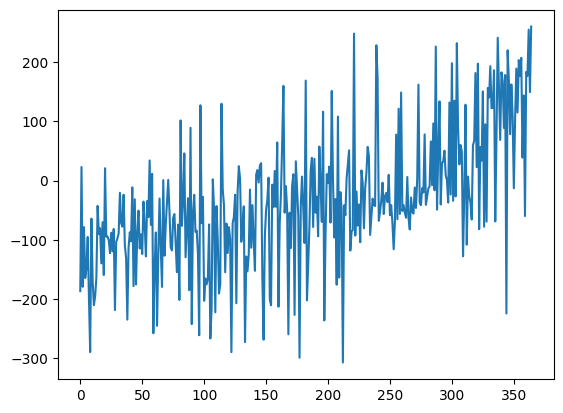

In [38]:
plt.plot(episode_rewards)
plt.show()

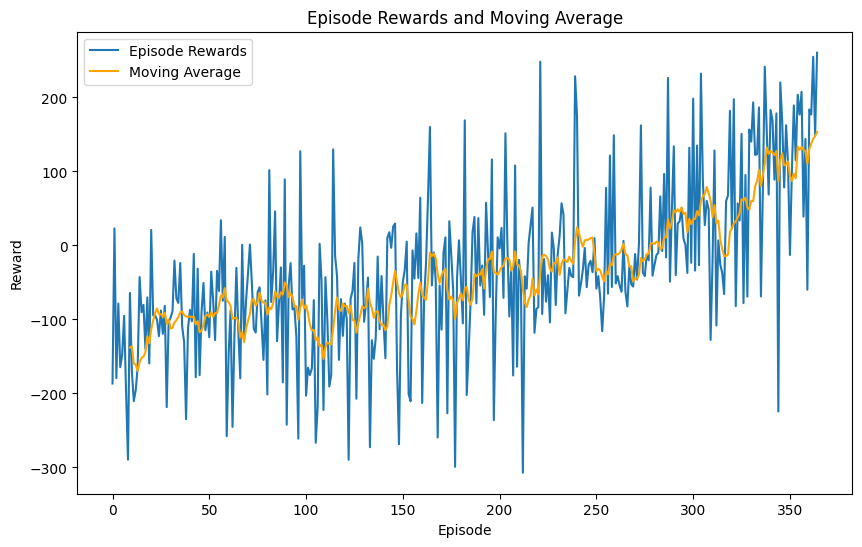

In [39]:
# Moving Average Plot
window = 10  # Size of the moving window
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Episode Rewards')
plt.plot(range(window-1, len(episode_rewards)), moving_avg, label='Moving Average', color='orange')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards and Moving Average')
plt.legend()
plt.show()

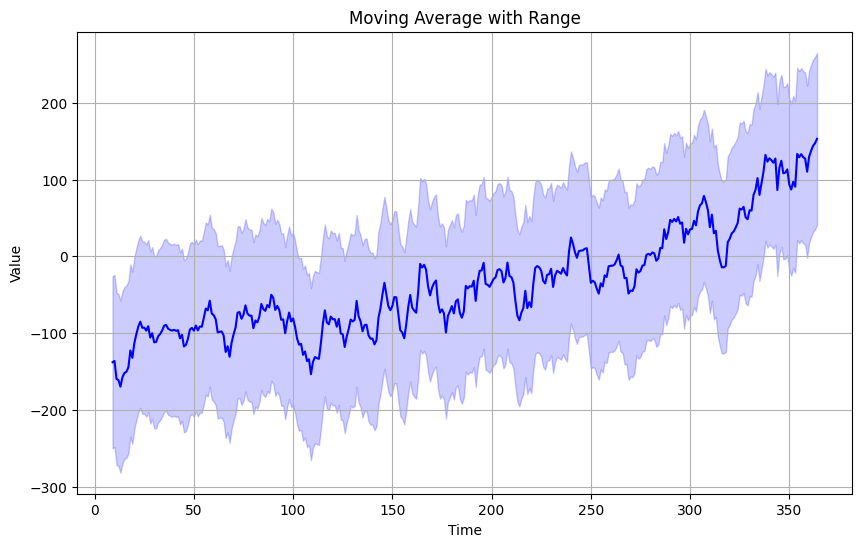

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some sample data
np.random.seed(0)
data = episode_rewards

# Calculate the moving average
window_size = 10
moving_avg = pd.Series(data).rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the moving average line
sns.lineplot(data=moving_avg, color='blue')

# Shade the area around the moving average line to represent the range of values
plt.fill_between(range(len(moving_avg)), 
                 moving_avg - np.std(data), 
                 moving_avg + np.std(data), 
                 color='blue', alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Moving Average with Range')
plt.grid(True)
plt.show()
